In [1]:
import sys 
sys.path.append("..") 
from utils import config
from utils.seq2seq.batcher import *
from utils.seq2seq.train_util import *
import argparse


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

parser = argparse.ArgumentParser()
parser.add_argument('--key_attention', type=bool, default=False, help = 'True/False')
parser.add_argument('--intra_encoder', type=bool, default=True, help = 'True/False')
parser.add_argument('--intra_decoder', type=bool, default=True, help = 'True/False')
parser.add_argument('--copy', type=bool, default=True, help = 'True/False') # for transformer

parser.add_argument('--model_type', type=str, default='seq2seq', choices=['seq2seq', 'transformer'])
parser.add_argument('--train_rl', type=bool, default=False, help = 'True/False')
parser.add_argument('--keywords', type=str, default='POS_keys', 
                    help = 'POS_keys / DEP_keys / Noun_adj_keys / TextRank_keys')

parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--rand_unif_init_mag', type=float, default=0.02)
parser.add_argument('--trunc_norm_init_std', type=float, default=0.001)
parser.add_argument('--mle_weight', type=float, default=1.0)
parser.add_argument('--gound_truth_prob', type=float, default=0.5)

parser.add_argument('--max_enc_steps', type=int, default=500)
parser.add_argument('--max_dec_steps', type=int, default=20)
parser.add_argument('--min_dec_steps', type=int, default=6)
parser.add_argument('--max_epochs', type=int, default=15)
parser.add_argument('--vocab_size', type=int, default=50000)
parser.add_argument('--beam_size', type=int, default=16)
parser.add_argument('--batch_size', type=int, default=1)

parser.add_argument('--hidden_dim', type=int, default=512)
parser.add_argument('--emb_dim', type=int, default=300)
parser.add_argument('--gradient_accum', type=int, default=1)

parser.add_argument('--word_emb_type', type=str, default='word2Vec', help='word2Vec/glove/FastText')
parser.add_argument('--pre_train_emb', type=bool, default=True, help = 'True/False') # 若pre_train_emb為false, 則emb type為NoPretrain

opt = parser.parse_args(args=[])
config = re_config(opt)


# Load Pointer-Generator Model

In [2]:
from create_model.pg import Model 
load_model_path = 'Pointer_generator_word2Vec_Intra_Atten.tar'
# load_model_path = 'Pointer_generator_word2Vec_Intra_Atten(Noun_adj_keys).tar'

import torch as T
T.backends.cudnn.benchmark = True 
checkpoint = T.load(load_model_path)
vocab = checkpoint['vocab']
print(load_model_path)

model = Model(pre_train_emb=config.pre_train_emb, 
              word_emb_type = config.word_emb_type, 
              vocab = vocab)

model = model.cuda()
model.load_state_dict(checkpoint['model'])
model.eval()

I0627 16:09:20.941918 139902634608448 file_utils.py:35] PyTorch version 1.4.0 available.


Pointer_generator_word2Vec_Intra_Atten.tar


I0627 16:09:28.636593 139902634608448 utils_any2vec.py:341] loading projection weights from /home/eagleuser/Users/leyan//Train-Data/Mix6_mainCat_Ekphrasis/Embedding/word2Vec/word2Vec.300d.txt


/home/eagleuser/Users/leyan//Train-Data/Mix6_mainCat_Ekphrasis/Embedding/word2Vec/word2Vec.300d.txt


I0627 16:09:37.414645 139902634608448 utils_any2vec.py:405] loaded (49385, 300) matrix from /home/eagleuser/Users/leyan//Train-Data/Mix6_mainCat_Ekphrasis/Embedding/word2Vec/word2Vec.300d.txt


Model(
  (encoder): Encoder(
    (lstm): LSTM(300, 512, batch_first=True, bidirectional=True)
    (reduce_h): Linear(in_features=1024, out_features=512, bias=True)
    (reduce_c): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (enc_attention): encoder_attention(
      (W_h): Linear(in_features=1024, out_features=1024, bias=False)
      (W_s): Linear(in_features=1024, out_features=1024, bias=True)
      (W_t): Linear(in_features=300, out_features=1024, bias=True)
      (v): Linear(in_features=1024, out_features=1, bias=False)
    )
    (dec_attention): decoder_attention(
      (W_prev): Linear(in_features=512, out_features=512, bias=False)
      (W_s): Linear(in_features=512, out_features=512, bias=True)
      (W_t): Linear(in_features=300, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (x_context): Linear(in_features=1324, out_features=300, bias=True)
    (x_key_context): Linear(in_features=1624

In [3]:
from utils.seq2seq.batcher import Example, Batch
import matplotlib.pyplot as plt

config.batch_size = 1
config.gound_truth_prob = 0.5

# data = {'review_ID':'',
#         'review':'this mongoose flat tire bike joke pretty easy assemble and gorgeous but catch tough the upper thigh area when you ride it . now been awhile since rode bike go take some get use too . never the less love this bike and make anyone look cool ride it .',
#         'summary':'it is pretty easy to assemble and it is gorgeous but there is',
#         'POS_keys': "['good', 'sound', 'static', 'terrible', 'listen', 'book', 'audio', 'speaker', 'recommend']",
#        "percent_lcs": '40.0'}

data = {'review_ID':'',
        'review':'i like this product . it ha worked for my dog that do not have plaque . i received a package of new prod en plaque off and the formula is very different from previou purchase . i am worried it will hurt my dog . i am going to purchase from an authorized seller from now on . i worried that i did not receive an authentic product .',
        'summary':'two star because of the look of my latest order it ha worked previously',
        'POS_keys': "['prod', 'package', 'plaque', 'formula', 'new', 'different', 'seller', 'authorized']",
       "percent_lcs": '21.4285714285714'}

ex = Example(config, vocab, data)
b = Batch([ex])

b.enc_pad_mask

enc_batch, enc_padding_mask, enc_lens, enc_batch_extend_vocab, extra_zeros, coverage, ct_e, enc_key_batch, enc_key_mask, enc_key_lens= \
                get_input_from_batch(b, config, batch_first = True)
dec_batch, dec_padding_mask, dec_lens, max_dec_len, target_batch = \
        get_output_from_batch(b, config, batch_first = True)

max_enc_len = max(T.max(enc_lens,dim=0)).tolist()[0]    

# plot_attention

In [4]:
def plot_enc_attention(data, X_label=None, Y_label=None):
    '''
    Plot the attention model heatmap
    Args:
      data: attn_matrix with shape [ty, tx], cutted before 'PAD'
      X_label: list of size tx, encoder tags
      Y_label: list of size ty, decoder tags
    '''
    fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
    #   heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.9)
    heatmap = ax.pcolor(data, cmap='viridis', alpha=0.9)
#     heatmap = ax.pcolor(data, cmap='hot', alpha=0.9)
    plt.colorbar(heatmap)
  
  # Set axis labels
    if X_label != None and Y_label != None:
        X_label = [x_label for x_label in X_label]
        Y_label = [y_label for y_label in Y_label]

        xticks = range(0,len(X_label))
        ax.set_xticks(xticks, minor=False) # major ticks
        ax.set_xticklabels(X_label, minor = False, rotation=90)   # labels should be 'unicode'
        plt.xlabel('review words')
        
        yticks = range(0,len(Y_label))
        ax.set_yticks(yticks, minor=False)
        ax.set_yticklabels(Y_label, minor = False)   # labels should be 'unicode'
        plt.ylabel('Summary words')
        plt.title('Intra-Encoder Attention')

        ax.grid(True)
        
        
        
def plot_dec_attention(data, X_label=None, Y_label=None):
    '''
    Plot the attention model heatmap
    Args:
      data: attn_matrix with shape [ty, tx], cutted before 'PAD'
      X_label: list of size tx, encoder tags
      Y_label: list of size ty, decoder tags
    '''
    fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.9)
#     heatmap = ax.pcolor(data, cmap='viridis', alpha=0.9)
#     heatmap = ax.pcolor(data, cmap='hot', alpha=0.9)
    plt.colorbar(heatmap)
  
  # Set axis labels
    if X_label != None and Y_label != None:
        X_label = [x_label for x_label in X_label]
        Y_label = [y_label for y_label in Y_label]

        xticks = range(0,len(X_label))
        ax.set_xticks(xticks, minor=False) # major ticks
        ax.set_xticklabels(X_label, minor = False, rotation=0)   # labels should be 'unicode'
        plt.xlabel('Decoded Summary words')
        
        yticks = range(0,len(Y_label))
        ax.set_yticks(yticks, minor=False)
        ax.set_yticklabels(Y_label, minor = False)   # labels should be 'unicode'
        plt.ylabel('Reference Summary words')
        plt.title('Intra-Decoder Attention')

        ax.grid(True)        

In [5]:
max_enc_len

70

In [6]:
decode = []
decode_2 = []
embed_words = []
with T.autograd.no_grad():
    enc_batch_ = model.embeds(enc_batch)  # Get embeddings for encoder input    
    enc_key_batch = model.embeds(enc_key_batch)  # Get key embeddings for encoder input
    enc_out, enc_hidden = model.encoder(enc_batch_, enc_lens, max_enc_len)

    s_t = (enc_hidden[0], enc_hidden[1])  # Decoder hidden states
    x_t = get_cuda(T.LongTensor(len(enc_out)).fill_(START))  # Input to the decoder
    prev_s = None  # Used for intra-decoder attention (section 2.2 in https://arxiv.org/pdf/1705.04304.pdf)
    sum_temporal_srcs = None  # Used for intra-temporal attention (section 2.1 in https://arxiv.org/pdf/1705.04304.pdf)
    weight = None
    dec_weight = []  

    for t in range(min(max_dec_len, config.max_dec_steps)):
        use_gound_truth = get_cuda((T.rand(len(enc_out)) > config.gound_truth_prob)).long()  # Probabilities indicating whether to use ground truth labels instead of previous decoded tokens
        x_t = use_gound_truth * dec_batch[:, t] + (1 - use_gound_truth) * x_t  # Select decoder input based on use_ground_truth probabilities
        embed_words.append(x_t.item())
        x_t = model.embeds(x_t)  
        final_dist, s_t, ct_e, sum_temporal_srcs, prev_s, enc_attn, dec_attn = model.decoder(x_t, s_t, enc_out, enc_padding_mask,
                                                                                  ct_e, extra_zeros,
                                                                                  enc_batch_extend_vocab,
                                                                                  sum_temporal_srcs, prev_s, enc_key_batch, enc_key_mask)

        x_t = T.max(final_dist, dim=1)[1]  # Sample words from final distribution which can be used as input in next time step

        
        if t == 0: 
            weight = enc_attn; 
        else: 
            weight = T.cat((weight, enc_attn), 0)  
        
        dec_weight.append(dec_attn) 
        
        decode.append(x_t.item())
        # x軸是tgt words
        # y軸是src words
    # print(weight.shape)
print(decode)

dec_words = [vocab.id2word(d) for d in decode]
dec_words = " ".join(dec_words) 
data['dec_words'] = dec_words
print('dec_words',dec_words)

# embed_words = embed_words[1:]
# print(embed_words)
embed_words = [vocab.id2word(d) for d in embed_words]
embed_words = " ".join(embed_words) 
data['embed_words'] = embed_words
print('embed_words',embed_words)
print('summary',data['summary'])

[1458, 463, 28, 8, 48, 43, 3, 7, 164, 164, 3, 3, 3, 3, 3]
dec_words i be like this product it [STOP] for dog dog [STOP] [STOP] [STOP] [STOP] [STOP]
embed_words [START] i star like this product look [STOP] my latest dog [STOP] ha worked previously
summary two star because of the look of my latest order it ha worked previously


In [7]:
sum_temporal_srcs.shape

torch.Size([1, 70])

# Intra-Temporal EncoderAttention可視化

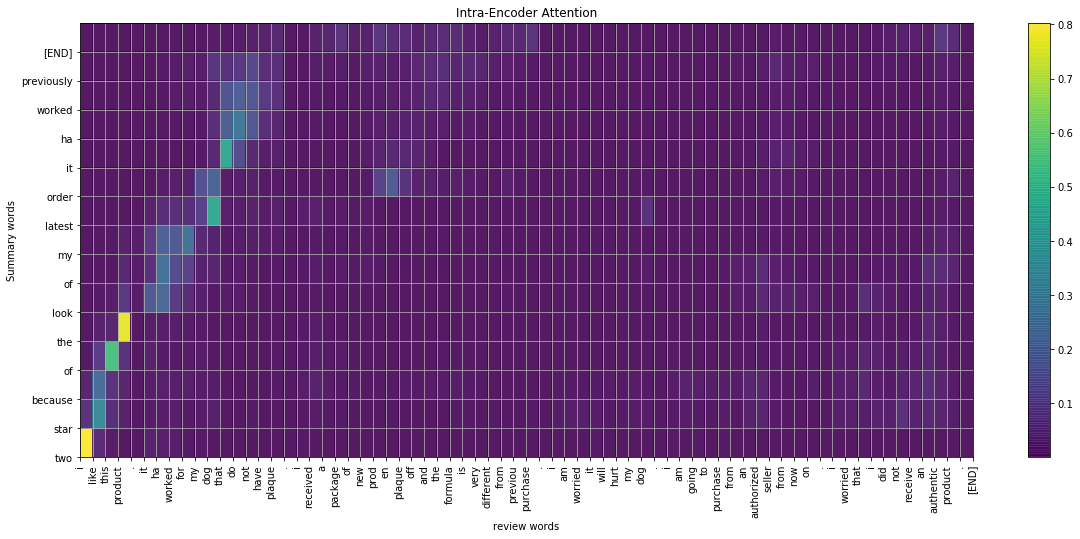

In [8]:
plot_enc_attention(weight.cpu().data, X_label=data['review'].split()+ ['[END]'], Y_label=data['summary'].split()+ ['[END]'])

In [9]:
dec_weight[1:]

[tensor([[1.]], device='cuda:0'),
 tensor([[0.2874, 0.7126]], device='cuda:0'),
 tensor([[0.1292, 0.3191, 0.5518]], device='cuda:0'),
 tensor([[0.1213, 0.0939, 0.2621, 0.5227]], device='cuda:0'),
 tensor([[0.0311, 0.0628, 0.2127, 0.2180, 0.4753]], device='cuda:0'),
 tensor([[0.1129, 0.0343, 0.0705, 0.0378, 0.1603, 0.5842]], device='cuda:0'),
 tensor([[0.0792, 0.0707, 0.0878, 0.0668, 0.1152, 0.1655, 0.4148]],
        device='cuda:0'),
 tensor([[0.0487, 0.0353, 0.0568, 0.0498, 0.0574, 0.0741, 0.2332, 0.4447]],
        device='cuda:0'),
 tensor([[0.0146, 0.0243, 0.0355, 0.0505, 0.0315, 0.0351, 0.1229, 0.2146, 0.4711]],
        device='cuda:0'),
 tensor([[0.0128, 0.0326, 0.0391, 0.0466, 0.0316, 0.0234, 0.0562, 0.1189, 0.2326,
          0.4060]], device='cuda:0'),
 tensor([[0.0058, 0.0363, 0.0395, 0.0346, 0.0191, 0.0135, 0.0287, 0.0685, 0.1160,
          0.1683, 0.4698]], device='cuda:0'),
 tensor([[0.0019, 0.0121, 0.0160, 0.0153, 0.0084, 0.0068, 0.0181, 0.0340, 0.0501,
          0.0555, 0.

# Sequential Intra-Decoder-Attention可視化

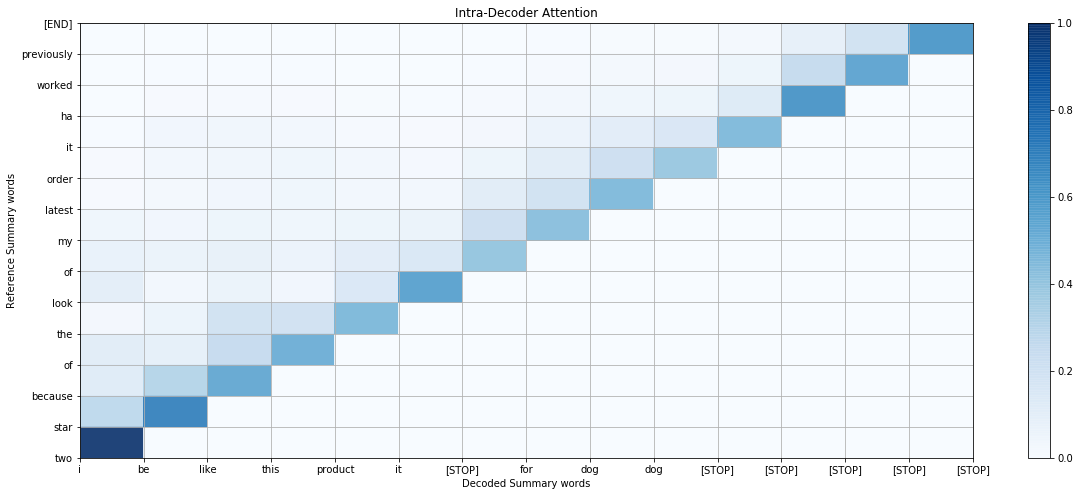

In [10]:
from torch import nn
import torch

new_dec_weight = None
for idx, w in enumerate(dec_weight[1:]):
    x = torch.tensor([[0.0]])
    w_ = x.repeat(1,len(decode)-(idx+2))
    new_w = torch.cat((w.cpu(), w_),dim=1)
    if idx == 0: new_dec_weight = new_w
    else: new_dec_weight = T.cat((new_dec_weight, new_w), 0) 



plot_dec_attention(new_dec_weight.data, X_label=data['dec_words'].split(),
                   Y_label=data['summary'].split()+ ['[END]'])

# 依照ground-true 0.5隨機使用summary token預測
# 每一個時間點的decode words 會調整自己過去關注的生成詞彙分布



In [11]:
dec_weight[1:][-1]

tensor([[4.2369e-04, 1.9654e-03, 2.5078e-03, 2.1530e-03, 1.2524e-03, 1.2834e-03,
         3.6418e-03, 7.5128e-03, 9.8536e-03, 1.0554e-02, 2.4495e-02, 9.1365e-02,
         2.1426e-01, 6.2873e-01]], device='cuda:0')